This project is to predict if the customer will subscribe (yes/no) to a term deposit (variable y).

**Data Description:**

- y - has the client subscribed to a term deposit? (binary) 
- age : age of customer (numeric)
- job : type of job (categorical)
- marital : marital status (categorical)
- education (categorical)
- default: has credit in default? (binary)
- balance: average yearly balance, in euros (numeric)
- housing: has a housing loan? (binary)
- loan: has personal loan? (binary)
- contact: contact communication type (categorical)
- day: last contact day of the month (numeric)
- month: last contact month of year (categorical)
- duration: last contact duration, in seconds (numeric)
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)


# Table of contents
- [EDA](#eda)
    - [1. Check datatype & missing values](#nan)
    - [2. Check duplicates](#dup)
    - [3. Check class ratio](#classratio)
    - [4. Data wrangling](#dw)
    - [5. Check distribution](#distribution)
    - [6. Check multicollinearity](#multicollinearity)
- [Data Split](#datasplit)
- [Modelling](#model)
    - [1. Logistic Regression](#logit)
    - [2. Decision Tree](#dt)
    - [3. Random Forest](#rf)
    - [4. XGB](#xgb)
- [Conclusion](#conclusion)
- [Feature Selection](#fs)
- [Prioritized Segment](#ps)

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, f1_score, accuracy_score

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
df=pd.read_csv('term-deposit-marketing-2020.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [3]:
print(f' This dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

 This dataset has 40000 rows and 14 columns.


# EDA <a class="anchor" id="eda"></a>

### 1. Check datatype & missing values <a class="anchor" id="nan"></a>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [5]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

### 2. Check duplicates <a class="anchor" id="dup"></a>

In [6]:
df.duplicated().sum()

0

### 3. Check class ratio <a class="anchor" id="classratio"></a>

In [7]:
# check class ratio
df['y'].value_counts(normalize=True)

no     0.9276
yes    0.0724
Name: y, dtype: float64

The dataset is heavily imbalanced. To deal with this, in terms of models, Decision trees frequently perform well on imbalanced data. However, tree ensembles (Random Forests, Gradient Boosted Trees, etc.) almost always outperform singular decision trees, so they will be candidates worth considering. Regarding approach, we would upsample the minority class, then optimize for **F1** score with `class_weight` hyperparameter.

### 4. Data wrangling <a class="anchor" id="dw"></a>

In [8]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [9]:
# binary mapping for yes-no columns
for i in ['default','housing','loan','y']:
    df[i]=df[i].map({'yes': 1, 'no': 0})

# sanity check
df.head()    

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,0


In [10]:
# turn month to numeric value
df['month']=df['month'].map({'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10,\
             'nov': 11, 'dec': 12, 'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4})

# sanity check
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,5,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,5,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,5,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,5,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,5,198,1,0


### 5. Check distribution <a class="anchor" id="distribution"></a>

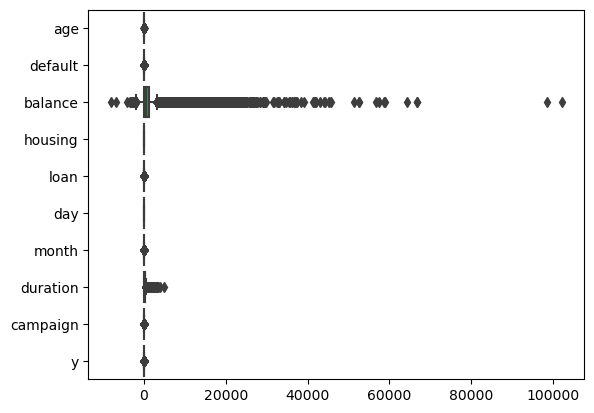

In [11]:
sns.boxplot(data=df, orient="h");

We see that `balance` is heavily right-skewed.

### 6. Check multicollinearity <a class="anchor" id="multicollinearity"></a>


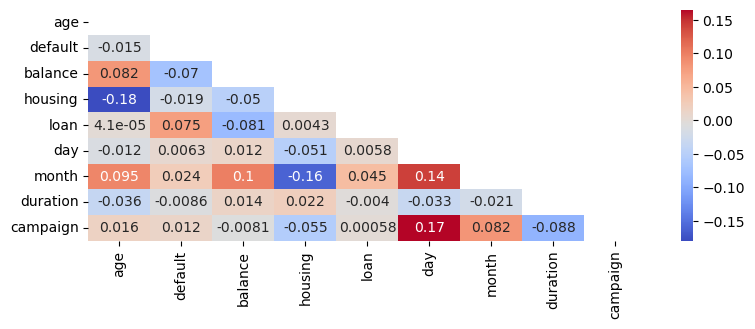

In [12]:
# heatmap of correlation
plt.figure(figsize=(9,3))
matrix = np.triu(df.drop(columns='y').corr())
sns.heatmap(df.drop(columns='y').corr(), annot=True, mask=matrix, cmap='coolwarm')
plt.show()

We see no multicollinearity between the variables, therefore no action is required.

# Data Split <a class="anchor" id="datasplit"></a>

In [13]:
X=df.drop(columns='y')
y=df['y']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [15]:
X_train.shape

(32000, 13)

In [16]:
X_test.shape

(8000, 13)

# Modelling <a class="anchor" id="model"></a>

## 1. Logistic Regression <a class="anchor" id="logit"></a>

In [17]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

imba_pipeline = make_pipeline(
            RandomOverSampler(random_state=101),        
            make_column_transformer((OneHotEncoder(drop = 'first'), 
                                    make_column_selector(dtype_include=object)),
                                    remainder='passthrough'),
            LogisticRegression(random_state=11, max_iter=1000))

param_grid = [{'logisticregression__solver':['lbfgs'],
               'logisticregression__penalty':['l2', 'None'],
               'logisticregression__C': [10**i for i in range (-4,4)],
               'logisticregression__class_weight': [{0:1,1:2},{0:1,1:3}, {0:1,1:4}, None],
               'randomoversampler__sampling_strategy': [1/2,1/3,1/4]},
              
              {'logisticregression__solver':['liblinear'],
               'logisticregression__penalty':['l1', 'l2'],
               'logisticregression__C': [10**i for i in range (-4,4)],
               'logisticregression__class_weight': [{0:1,1:2},{0:1,1:3}, {0:1,1:4}, None],
               'randomoversampler__sampling_strategy': [1/2,1/3,1/4]}, 
              
              {'logisticregression__solver':['newton-cg'],
               'logisticregression__penalty':['l2', 'None'],
               'logisticregression__C': [10**i for i in range (-4,4)],
               'logisticregression__class_weight': [{0:1,1:2},{0:1,1:3}, {0:1,1:4}, None],
               'randomoversampler__sampling_strategy': [1/2,1/3,1/4]}, 
              
              {'logisticregression__solver':['sag'],
               'logisticregression__penalty':['l2', 'None'],
               'logisticregression__C': [10**i for i in range (-4,4)],
               'logisticregression__class_weight': [{0:1,1:2},{0:1,1:3}, {0:1,1:4}, None],
               'randomoversampler__sampling_strategy': [1/2,1/3,1/4]}, 
              
              {'logisticregression__solver':['saga'],
               'logisticregression__penalty':['l1', 'l2', 'elasticnet', 'None'],
               'logisticregression__C': [10**i for i in range (-4,4)],
               'logisticregression__class_weight': [{0:1,1:2},{0:1,1:3}, {0:1,1:4}, None],
               'randomoversampler__sampling_strategy': [1/2,1/3,1/4]} ]

logit = RandomizedSearchCV(imba_pipeline, param_grid, scoring='f1', cv=kf, n_jobs = -1, verbose=1, random_state=545)
logit_fitted = logit.fit(X_train, y_train)

print(f'\nBest param: {logit_fitted.best_params_}')

# mean validation score
print(f"\nMean validation's F1 score: {logit_fitted.cv_results_['mean_test_score'].mean()}")

# score
print('\nTrain accuracy: %.3f' % accuracy_score(y_train, logit_fitted.predict(X_train)))
print('Test accuracy: %.3f' % accuracy_score(y_test, logit_fitted.predict(X_test)))
print('Accuracy difference: %.3f' % (accuracy_score(y_train, logit_fitted.predict(X_train))-accuracy_score(y_test, logit_fitted.predict(X_test))).round(4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best param: {'randomoversampler__sampling_strategy': 0.3333333333333333, 'logisticregression__solver': 'newton-cg', 'logisticregression__penalty': 'l2', 'logisticregression__class_weight': None, 'logisticregression__C': 10}

Mean validation's F1 score: nan

Train accuracy: 0.919
Test accuracy: 0.914
Accuracy difference: 0.005


In [18]:
# look at classification_report
y_pred = logit_fitted.predict(X_test)
print(classification_report(y_test, y_pred))

print(f'>>>>>>>>> F1 score on test set: {f1_score(y_test,y_pred)}')

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7421
           1       0.42      0.54      0.47       579

    accuracy                           0.91      8000
   macro avg       0.69      0.74      0.71      8000
weighted avg       0.92      0.91      0.92      8000

>>>>>>>>> F1 score on test set: 0.4729214340198322


## 2. Decision Tree <a class="anchor" id="dt"></a>

In [19]:
class_counts=y_train.value_counts()
total_samples=len(y_train)
cw = {0: total_samples/(2*class_counts[0]),\
      1: total_samples/(2*class_counts[1]),}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

imba_pipeline = make_pipeline(
            RandomOverSampler(random_state=101),
            make_column_transformer((OneHotEncoder(drop = 'first'), 
                                    make_column_selector(dtype_include=object)),
                                    remainder='passthrough'),
            DecisionTreeClassifier(random_state=999))

param_grid = {'decisiontreeclassifier__max_depth': list(range(2,11)),
              'decisiontreeclassifier__min_samples_split':list(range(5,21)),         
              'decisiontreeclassifier__min_samples_leaf':list(range(5,21)),         
              'decisiontreeclassifier__max_features':list(range(2,14)),
              'decisiontreeclassifier__max_leaf_nodes':list(range(5,51,5)),
              'decisiontreeclassifier__min_impurity_decrease':[10**i for i in range (-6,-2)],
              'decisiontreeclassifier__class_weight':[cw,None],
              'randomoversampler__sampling_strategy': [1/2,1/3,1/4]}

dt = RandomizedSearchCV(imba_pipeline, param_grid, scoring='f1', cv=kf, n_jobs = -1, verbose=1, random_state=545)
dt_fitted = dt.fit(X_train, y_train)

print(f'\nBest param: {dt_fitted.best_params_}')

# mean validation score
print(f"\nMean validation's F1 score: {dt_fitted.cv_results_['mean_test_score'].mean()}")

# score
print('\nTrain accuracy: %.3f' % accuracy_score(y_train, dt_fitted.predict(X_train)))
print('Test accuracy: %.3f' % accuracy_score(y_test, dt_fitted.predict(X_test)))
print('Accuracy difference: %.3f' % (accuracy_score(y_train, dt_fitted.predict(X_train))-accuracy_score(y_test, dt_fitted.predict(X_test))).round(4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best param: {'randomoversampler__sampling_strategy': 0.3333333333333333, 'decisiontreeclassifier__min_samples_split': 12, 'decisiontreeclassifier__min_samples_leaf': 16, 'decisiontreeclassifier__min_impurity_decrease': 0.0001, 'decisiontreeclassifier__max_leaf_nodes': 50, 'decisiontreeclassifier__max_features': 7, 'decisiontreeclassifier__max_depth': 6, 'decisiontreeclassifier__class_weight': None}

Mean validation's F1 score: 0.21141237643200766

Train accuracy: 0.892
Test accuracy: 0.885
Accuracy difference: 0.007


In [20]:
# look at classification_report
y_pred = dt_fitted.predict(X_test)
print(classification_report(y_test, y_pred))

print(f'>>>>>>>>> F1 score on test set: {f1_score(y_test,y_pred)}')

              precision    recall  f1-score   support

           0       0.97      0.90      0.94      7421
           1       0.35      0.66      0.45       579

    accuracy                           0.89      8000
   macro avg       0.66      0.78      0.69      8000
weighted avg       0.93      0.89      0.90      8000

>>>>>>>>> F1 score on test set: 0.4536817102137767


## 3. Random Forest <a class="anchor" id="rf"></a>

In [21]:
class_counts=y_train.value_counts()
total_samples=len(y_train)
cw = {0: total_samples/(2*class_counts[0]),\
      1: total_samples/(2*class_counts[1]),}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

imba_pipeline = make_pipeline(
            RandomOverSampler(random_state=101),
            make_column_transformer((OneHotEncoder(drop = 'first'), 
                                    make_column_selector(dtype_include=object)),
                                    remainder='passthrough'),
            RandomForestClassifier(random_state=1, class_weight=cw))

# set up params
param_grid = {'randomforestclassifier__n_estimators':list(range(5,101,5)),
              'randomforestclassifier__max_depth':list(range(2,11)),
              'randomforestclassifier__min_samples_leaf':list(range(5,21)),         
              'randomforestclassifier__min_samples_split':list(range(5,21)),         
              'randomforestclassifier__max_features':list(range(2,14)),
              'randomforestclassifier__max_leaf_nodes':list(range(5,51,5)),
              'randomforestclassifier__min_impurity_decrease':[10**i for i in range (-6,-2)],
              'randomforestclassifier__class_weight':[cw, None],
              'randomoversampler__sampling_strategy': [1/2,1/3,1/4]}

rf = RandomizedSearchCV(imba_pipeline, param_grid, scoring = 'f1', cv=kf, n_jobs = -1, verbose=1, random_state=545)
rf_fitted = rf.fit(X_train, y_train)

print(f'\nBest param: {rf_fitted.best_params_}')

# mean validation score
print(f"\nMean validation's F1 score: {rf_fitted.cv_results_['mean_test_score'].mean()}")

# score
print('\nTrain accuracy: %.3f' % accuracy_score(y_train, rf_fitted.predict(X_train)))
print('Test accuracy: %.3f' % accuracy_score(y_test, rf_fitted.predict(X_test)))
print('Accuracy difference: %.3f' % (accuracy_score(y_train, rf_fitted.predict(X_train))-accuracy_score(y_test, rf_fitted.predict(X_test))).round(4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best param: {'randomoversampler__sampling_strategy': 0.5, 'randomforestclassifier__n_estimators': 40, 'randomforestclassifier__min_samples_split': 11, 'randomforestclassifier__min_samples_leaf': 20, 'randomforestclassifier__min_impurity_decrease': 1e-06, 'randomforestclassifier__max_leaf_nodes': 25, 'randomforestclassifier__max_features': 12, 'randomforestclassifier__max_depth': 6, 'randomforestclassifier__class_weight': None}

Mean validation's F1 score: 0.3723589150153071

Train accuracy: 0.893
Test accuracy: 0.893
Accuracy difference: -0.000


In [22]:
# look at classification_report
y_pred = rf_fitted.predict(X_test)
print(classification_report(y_test, y_pred))

print(f'>>>>>>>>> F1 score on test set: {f1_score(y_test,y_pred)}')

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      7421
           1       0.39      0.81      0.52       579

    accuracy                           0.89      8000
   macro avg       0.69      0.86      0.73      8000
weighted avg       0.94      0.89      0.91      8000

>>>>>>>>> F1 score on test set: 0.5245535714285714


# 4. XGBoost <a class="anchor" id="xgb"></a>

In [23]:
class_counts=y_train.value_counts()
class_weight= class_counts[0]/class_counts[1]

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

imba_pipeline = make_pipeline(
            RandomOverSampler(random_state=101),
            make_column_transformer((OneHotEncoder(drop = 'first'), 
                                    make_column_selector(dtype_include=object)),
                                    remainder='passthrough'),
            XGBClassifier(random_state=22))

# set up params
param_grid = {
    'xgbclassifier__n_estimators': list(range(5,101,5)),
    'xgbclassifier__max_depth': list(range(2,11)),
    'xgbclassifier__learning_rate': list(np.arange(0.0001,0.011,0.0001)),
    'xgbclassifier__lambda': list(np.arange(0.0001,0.011,0.0001)),
    'xgbclassifier__gamma': list(np.arange(0.0001,0.011,0.0001)),
    'xgbclassifier__scale_pos_weight': [class_weight,None],
    'randomoversampler__sampling_strategy': [1/2,1/3,1/4]}

xg = RandomizedSearchCV(imba_pipeline, param_grid, scoring='f1', cv=kf, n_jobs = -1, verbose=1, random_state=545)
xg_fitted = xg.fit(X_train, y_train)

print(f'\nBest param: {xg_fitted.best_params_}')

# mean validation score
print(f"\nMean validation's F1 score: {xg_fitted.cv_results_['mean_test_score'].mean()}")

# score
print('\nTrain accuracy: %.3f' % accuracy_score(y_train, xg_fitted.predict(X_train)))
print('Test accuracy: %.3f' % accuracy_score(y_test, xg_fitted.predict(X_test)))
print('Accuracy difference: %.3f' % (accuracy_score(y_train, xg_fitted.predict(X_train))-accuracy_score(y_test, xg_fitted.predict(X_test))).round(4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best param: {'xgbclassifier__scale_pos_weight': None, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_depth': 8, 'xgbclassifier__learning_rate': 0.0107, 'xgbclassifier__lambda': 0.01, 'xgbclassifier__gamma': 0.0087, 'randomoversampler__sampling_strategy': 0.3333333333333333}

Mean validation's F1 score: 0.441205349748817

Train accuracy: 0.928
Test accuracy: 0.912
Accuracy difference: 0.015


In [24]:
# look at classification_report
y_pred = xg_fitted.predict(X_test)
print(classification_report(y_test, y_pred))

print(f'>>>>>>>>> F1 score on test set: {f1_score(y_test,y_pred)}')

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      7421
           1       0.44      0.77      0.56       579

    accuracy                           0.91      8000
   macro avg       0.71      0.85      0.75      8000
weighted avg       0.94      0.91      0.92      8000

>>>>>>>>> F1 score on test set: 0.5584905660377358


Metric         | Logistic Regression |Decision Tree |Random Forest |XGBoost        
---------------|---------------------|--------------|--------------|-------
Train Accuracy | 0.919               |0.892         | 0.893        | 0.928
Test Accuracy  | 0.914               |0.885         | 0.893        | 0.912
F1 score       | 0.47                |0.45          | 0.52         | 0.56

---

Looking at the result table, we see that XGBoost outperforms other models with the highest accuracy and f1 scores. Therefore, I would choose it as the optimal model for this dataset.

# Threshold Adjustment <a class="anchor" id="ta"></a>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


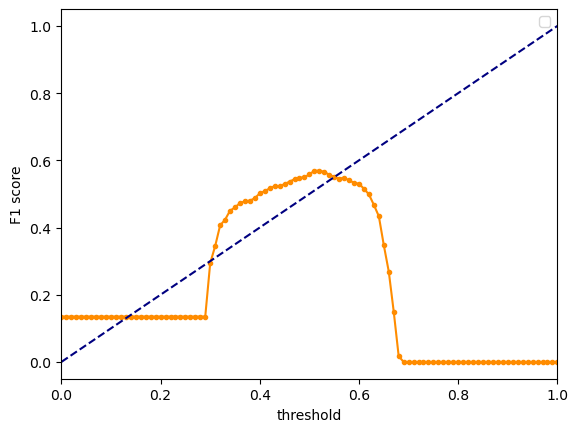

In [25]:
thresholds = np.arange(0, 1.1, 0.01)
f1 = []

y_test_proba=xg_fitted.predict_proba(X_test)[:, 1]

for threshold in thresholds:

    # Apply threshold
    y_threshold = np.where(y_test_proba >= threshold, 1, 0)
    f1.append(f1_score(y_test, y_threshold))

# plot    
plt.figure()
plt.plot(thresholds, f1, color='darkorange', marker='.')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim(0, 1)
plt.xlabel('threshold')
plt.ylabel('F1 score')
plt.legend()
plt.show()

In [26]:
# get index of the highest f1
highest_f1_index=np.argmax(f1)

# get the threshold giving the highest f1 
optimal_threshold=thresholds[highest_f1_index]

print(f'Optimal threshold: {optimal_threshold}')
print(f'\nHighest F1 score: {f1[highest_f1_index]}')

Optimal threshold: 0.52

Highest F1 score: 0.5693135935397039


Let's see how much accuracy score we can get with this threshold.

In [27]:
y_train_proba=xg_fitted.predict_proba(X_train)[:, 1]
y_test_proba=xg_fitted.predict_proba(X_test)[:, 1]

y_train_threshold = np.where(y_train_proba >= optimal_threshold, 1, 0)
y_test_threshold = np.where(y_test_proba >= optimal_threshold, 1, 0)

print(f'Train Accuracy: %.3f' % accuracy_score(y_train, y_train_threshold))
print(f'Test Accuracy: %.3f' % accuracy_score(y_test, y_test_threshold))
print(f'Accuracy difference:  %.3f' % (accuracy_score(y_train, y_train_threshold)-accuracy_score(y_test, y_test_threshold)).round(4))

Train Accuracy: 0.935
Test Accuracy: 0.920
Accuracy difference:  0.015


# Conclusion <a class="anchor" id="conclusion"></a>

Afterall, I would choose XGBoost at threshold **0.52** as the optimal model for this dataset.

# Feature Selection <a class="anchor" id="fs"></a>

Since this dataset contains a mix of categorical and numeric values, I would utilize **Feature Importance** since it can select features across categorical and numeric types.

Importance scores will be derived from the most optimal model that has been found - XGBoost.

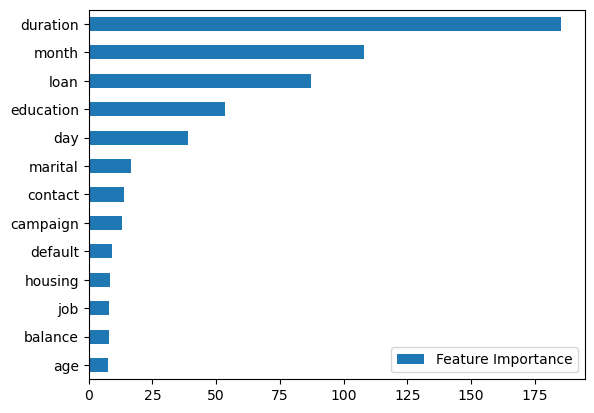

In [34]:
# In the final model, I would apply OneHotEncode (OHE) for the categorical features, 
# but to determine feature importance, I don't want to expand the columns with OHE, 
# also I believe that we'll get more value out of treating them as one column with ordinal encoded values.

fs_pipeline = make_pipeline(
            RandomOverSampler(random_state=101, sampling_strategy=1/3),
            make_column_transformer((OrdinalEncoder(), 
                                     make_column_selector(dtype_include=object)),
                                     remainder='passthrough'),
            XGBClassifier(random_state=22, 
                        n_estimators=50,
                        max_depth=8,
                        learning_rate=0.0107,
                        reg_lambda=0.01,
                        gamma=0.0087))

xg_fs = fs_pipeline.fit(X_train, y_train)

# get feature importance
f_importance=xg_fs.named_steps['xgbclassifier'].get_booster().get_score(importance_type='gain')

# put into a dataframe
importance_df = pd.DataFrame(f_importance.values(), index=X_train.columns, columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)
importance_df.sort_values(by='Feature Importance').plot.barh()
plt.show()

We see that `duration` scores exceptionally higher than other features, while `balance` surprisingly ranks almost last in terms of importance level.

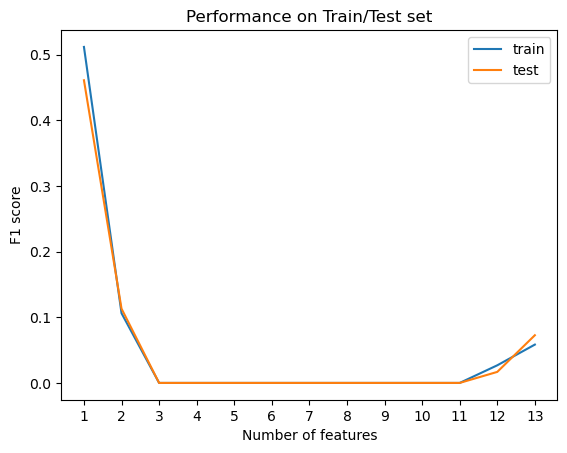

In [39]:
# let's look at how different sets of top features work
fs = make_pipeline(
            RandomOverSampler(random_state=101, sampling_strategy=1/3),
            make_column_transformer((OneHotEncoder(drop = 'first'), 
                                    make_column_selector(dtype_include=object)),
                                    remainder='passthrough'),
            XGBClassifier(random_state=22, 
                        n_estimators=50,
                        max_depth=8,
                        learning_rate=0.0107,
                        reg_lambda=0.01,
                        gamma=0.0087))
train_f1=[]
test_f1=[]

for i in range (len(importance_df.index)):
    # define dataframes
    X_train_fs=X_train[[importance_df.index[i]]]
    X_test_fs=X_test[[importance_df.index[i]]]

    # fit
    fs.fit(X_train_fs, y_train)
    
    # predict 
    y_train_proba=fs.predict_proba(X_train_fs)[:, 1]
    y_test_proba=fs.predict_proba(X_test_fs)[:, 1]

    # apply optimal threshold
    y_train_threshold = np.where(y_train_proba >= 0.52, 1, 0)
    y_test_threshold = np.where(y_test_proba >= 0.52, 1, 0)
    
    #score
    train_f1.append(f1_score(y_train, y_train_threshold))
    test_f1.append(f1_score(y_test, y_test_threshold))

#plot
plt.figure()
plt.plot(range(1,len(importance_df.index)+1), train_f1, label="train")
plt.plot(range(1,len(importance_df.index)+1), test_f1, label="test")
plt.xticks(range(1,len(importance_df.index)+1))
plt.xlabel('Number of features')
plt.ylabel("F1 score")
plt.title("Performance on Train/Test set")
plt.legend()
plt.show()


We see that adding more features after `duration` drops F1 scores dramatically, and it starts to plateau at 0 after 3 features. Therefore, `duration` and `month` could be said to be the most important features. 

Let's see the picture of registers and non-registers.

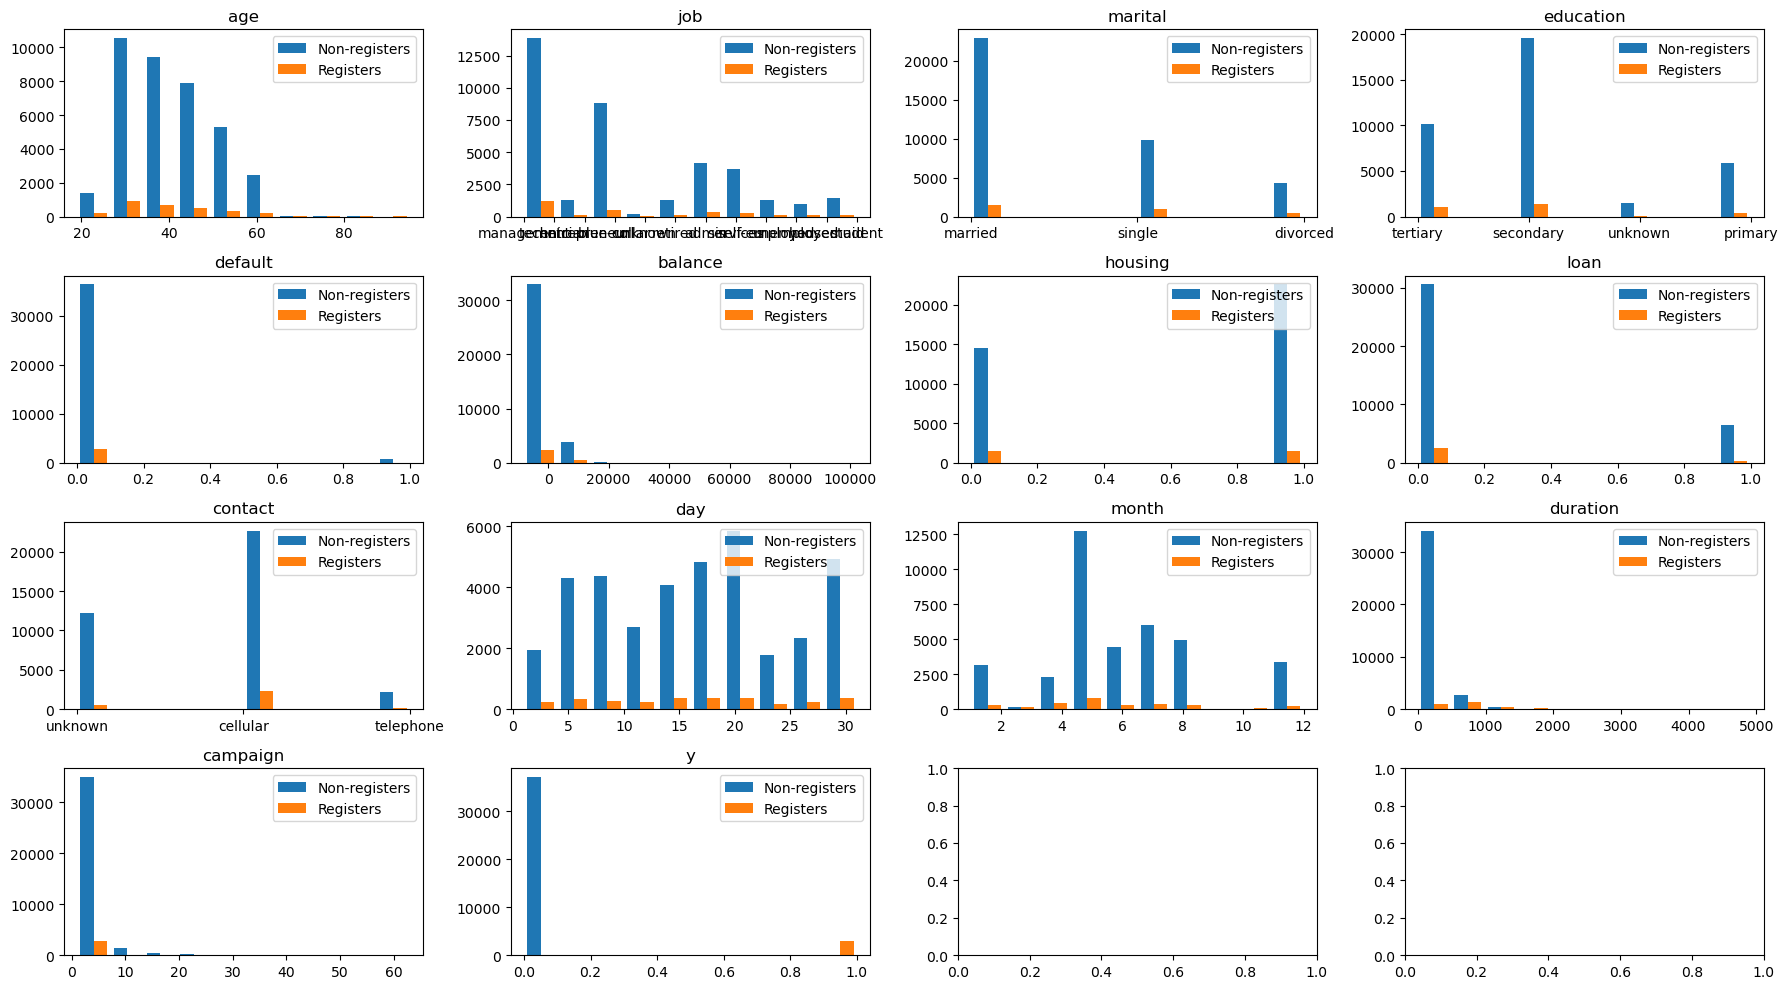

In [30]:
# Plot histogram distribution for registers and non-registers
non_registers=df[df['y']==0]
registers=df[df['y']==1]

plt.subplots(4,4, figsize=(18,10))
for i in range (14):
    plt.subplot(4,4,i+1)
    plt.hist([non_registers.iloc[:,i], registers.iloc[:,i]], label=['Non-registers', 'Registers'] )
    plt.title(registers.iloc[:,i].name)
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

We can see that **May** tends to be the most productive month in the year, and **long-duration calls** are more likely to influence the customers.

# Prioritized Segment <a class="anchor" id="ps"></a>

Let's look at those who the model predicts to register but they turn out not.

In [36]:
# predict the whole dataset
y_df_proba=xg_fitted.predict_proba(df.drop(columns=['y']))[:, 1]
y_df_threshold = np.where(y_df_proba >= 0.52, 1, 0)

# add prediction to the dataset
df['Prediction']=y_df_threshold

# filter out the segment
prioritized_segment=df.where((df['Prediction']==1) & (df['y']==0)).dropna()
prioritized_segment

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y,Prediction
37,53.0,technician,married,secondary,0.0,-3.0,0.0,0.0,unknown,5.0,5.0,1666.0,1.0,0.0,1.0
43,54.0,retired,married,secondary,0.0,529.0,1.0,0.0,unknown,5.0,5.0,1492.0,1.0,0.0,1.0
59,46.0,services,married,primary,0.0,179.0,1.0,0.0,unknown,5.0,5.0,1778.0,1.0,0.0,1.0
61,53.0,technician,divorced,secondary,0.0,989.0,1.0,0.0,unknown,5.0,5.0,812.0,1.0,0.0,1.0
109,45.0,management,married,tertiary,0.0,523.0,1.0,0.0,unknown,5.0,5.0,849.0,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39960,27.0,technician,single,tertiary,0.0,200.0,0.0,0.0,cellular,3.0,6.0,508.0,1.0,0.0,1.0
39991,33.0,services,single,tertiary,0.0,1268.0,1.0,0.0,cellular,3.0,6.0,2219.0,1.0,0.0,1.0
39992,45.0,technician,married,secondary,0.0,406.0,1.0,0.0,cellular,3.0,6.0,240.0,1.0,0.0,1.0
39994,35.0,management,married,tertiary,0.0,3109.0,1.0,0.0,cellular,3.0,6.0,467.0,1.0,0.0,1.0


These **2153** customers are those who the model predicts that they should have been registers but actually not, which implies that they are very likely to be a success in the next calls. Therefore, it is recommended to put more marketing effort into these customers.